# POTENTIALLY RESCALE AD BY DIVIDING BY N

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

from scipy.stats import norm, t as student_t, kstest
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from arch import arch_model

In [2]:
START = "2000-01-01"
END = "2020-01-01"

# Download historical data for S&P 500
ticker = "^GSPC"
data = yf.download(ticker, start=START, end=END)

/var/folders/0h/5y6llkfn0qbgrw_pl9pcf8wc0000gn/T/ipykernel_49992/1315326410.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


In [3]:
close_prices = data['Close'] # close prices (adjusted close not available for ^GSPC)
log_returns = np.log(close_prices).diff().dropna() # log returns
log_rets = log_returns.values

# CV Model

In [4]:
mu_norm = np.mean(log_rets) # sample mean
sigma_norm = np.std(log_rets, ddof=1) # sample standard deviation

resid_norm = (log_rets - mu_norm) / sigma_norm # normalised residuals

ks_stat_norm = stats.kstest(resid_norm, 'norm').statistic # Kolmogorov-Smirnov statistic



# MLE for t-distribution parameters
def neg_log_likelihood_t(params, data):
    mu, sigma, nu = params
    if sigma <= 0 or nu <= 2:
        return np.inf
    return -np.sum(student_t.logpdf(data, df=nu, loc=mu, scale=sigma))

# Initial guesses and bounds
theta_0 = [mu_norm, sigma_norm, 5.0]
bounds = [(-np.inf, np.inf), (1e-6, np.inf), (2.01, np.inf)]

# Optimize
mle_t = minimize(neg_log_likelihood_t, theta_0, args=(log_rets,), bounds=bounds)
mu_t, sigma_t, nu_t = mle_t.x # MLE estimates

resid_t = (log_rets - mu_t) / sigma_t # t-distribution residuals

ks_stat_t = stats.kstest(resid_t, 't', args=(nu_t,)).statistic # Kolmogorov-Smirnov statistic
# mannually computed ad_stat_t since scipy does not support t-distribution
def anderson_darling(data, cdf):
    x = np.sort(data)
    n = data.size
    i = np.arange(1, n + 1)
    F = np.clip(cdf(x), 1e-10, 1 - 1e-10)
    s = np.sum((2 * i - 1) * (np.log(F) + np.log(1 - F[::-1])))
    A2 = -n - s / n
    return A2

# Anderson-Darling statistics
ad_stat_norm = anderson_darling(resid_norm, lambda x: stats.norm.cdf(x))
ad_stat_norm = ad_stat_norm/len(resid_norm)  # normalise by sample size

ad_stat_t = anderson_darling(resid_t, lambda x: student_t.cdf(x, df=nu_t))
ad_stat_t = ad_stat_t/len(resid_t)  # normalise by sample size
log_likelihood_t = -neg_log_likelihood_t(mle_t.x, log_rets)

alpha = 0.01
n = len(log_rets)
ks_crit = 1.63 / np.sqrt(n)




In [5]:
ks_stats = [ks_stat_norm, ks_stat_t] # Kolmogorov-Smirnov statistics
ad_stats = [ad_stat_norm, ad_stat_t] # Anderson-Darling statistics
ks_test_results = ['Reject' if ks > ks_crit else 'Fail to Reject' for ks in ks_stats] # KS test results


In [6]:
# Summary of results
results_cv = pd.DataFrame({
    'Model': ['CV-Normal', 'CV-Student\'s t'],
    'Parameters': [f'μ={mu_norm:.5f}, σ={sigma_norm:.5f}', f'μ={mu_t:.5f}, σ={sigma_t:.5f}, ν={nu_t:.2f}'],
    'KS Statistic': [ks_stat_norm, ks_stat_t],
    'KS 1% Crit Value': [ks_crit, ks_crit],
    'KS Test Result': ks_test_results,
    'AD Statistic': [ad_stat_norm, ad_stat_t]
})
print(results_cv)

            Model                    Parameters           KS Statistic  \
0       CV-Normal          μ=0.00016, σ=0.01190  [0.09426908727112349]   
1  CV-Student's t  μ=0.00059, σ=0.00684, ν=2.57  [0.02051633681045921]   

   KS 1% Crit Value  KS Test Result  AD Statistic  
0          0.022983          Reject   9884.119042  
1          0.022983  Fail to Reject  10059.468330  


# GARCH

In [7]:
y = log_rets.astype(float)

### normal-GARCH(1,1)

In [8]:
garch_norm = arch_model(log_rets, mean='Constant', vol = 'GARCH', p=1, q=1, dist='normal') # GARCH(1,1) with normal errors
res_garch_norm = garch_norm.fit(disp='off') # fit model

/Users/neiltamhankar/Desktop/Master of Financial Mathematics/Sem 2 2025/MTH5510/MTH5510 Assignment 3/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [9]:
garch_norm_params = res_garch_norm.params # extract parameters
omega_norm = garch_norm_params['omega']
alpha_norm = garch_norm_params['alpha[1]']
beta_norm = garch_norm_params['beta[1]']
mu_garch_norm = garch_norm_params['mu']

resid_garch_norm = res_garch_norm.std_resid # standardized residuals

In [10]:
ks_garch_norm = stats.kstest(resid_garch_norm, 'norm')
ks_stat_garch_norm = ks_garch_norm.statistic

ad_stat_garch_norm = anderson_darling(resid_garch_norm, lambda x: stats.norm.cdf(x))
ad_stat_garch_norm = ad_stat_garch_norm/len(resid_garch_norm)  # normalise by sample size
ad_crit_garch_norm = 1.092  # 1% significance level



### t-GARCH(1,1)

In [11]:
garch_t = arch_model(log_rets, mean='Constant', vol = 'GARCH', p=1, q=1, dist='t') # GARCH(1,1) with t-distributed errors
res_garch_t = garch_t.fit(disp='off') # fit model

garch_t_params = res_garch_t.params # extract parameters
omega_t = garch_t_params['omega']
alpha_t = garch_t_params['alpha[1]']
beta_t = garch_t_params['beta[1]']
nu_garch_t = garch_t_params['nu']
mu_garch_t = garch_t_params['mu']

resid_garch_t = res_garch_t.std_resid
ks_garch_t = stats.kstest(resid_garch_t, 't', args=(nu_garch_t,)) # Kolmogorov-Smirnov statistic
ks_stat_garch_t = ks_garch_t.statistic

ad_stat_garch_t = anderson_darling(resid_garch_t, lambda x: stats.t.cdf(x, nu_garch_t))
ad_stat_garch_t = ad_stat_garch_t/len(resid_garch_t)  # normalise by sample size



/Users/neiltamhankar/Desktop/Master of Financial Mathematics/Sem 2 2025/MTH5510/MTH5510 Assignment 3/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Tests

In [12]:
ks_crit = 1.63 / np.sqrt(n)
ks_garch_norm_result = 'Reject' if ks_stat_garch_norm > ks_crit else 'Fail to Reject' # KS test result
ks_garch_t_result = 'Reject' if ks_stat_garch_t > ks_crit else 'Fail to Reject' # KS test result

In [13]:
# Summary of GARCH results
results_garch = pd.DataFrame({
    'Model': ['GARCH-Normal', 'GARCH-Student\'s t'],
    'Parameters': [f'μ={mu_garch_norm:.5f}, ω={omega_norm:.5e}, α={alpha_norm:.5f}, β={beta_norm:.5f}',
                   f'μ={mu_garch_t:.5f}, ω={omega_t:.5e}, α={alpha_t:.5f}, β={beta_t:.5f}, ν={nu_garch_t:.2f}'],
    'KS Statistic': [ks_stat_garch_norm, ks_stat_garch_t],
    'KS 1% Crit Value': [ks_crit, ks_crit],
    'KS Test Result': [ks_garch_norm_result, ks_garch_t_result],
    'AD Statistic': [ad_stat_garch_norm, ad_stat_garch_t]
})
print(results_garch)

               Model                                         Parameters  \
0       GARCH-Normal     μ=0.20243, ω=3.17781e-06, α=0.10022, β=0.88003   
1  GARCH-Student's t  μ=0.00029, ω=1.36998e-03, α=0.99987, β=0.00010...   

   KS Statistic  KS 1% Crit Value KS Test Result  AD Statistic  
0      0.808396          0.022983         Reject      1.073435  
1      0.290623          0.022983         Reject      0.196062  


# ARMA-GARCH

### normal-ARMA(1,1)-GARCH(1,1)

In [14]:
import armagarch as ag

In [15]:
y = log_rets.astype(float)
n = len(y)

In [16]:
arma_garch_norm = arch_model(y, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal') # ARMA(1,1)-GARCH(1,1) with normal errors
res_arma_garch_norm = arma_garch_norm.fit(disp='off') # fit model

/Users/neiltamhankar/Desktop/Master of Financial Mathematics/Sem 2 2025/MTH5510/MTH5510 Assignment 3/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [17]:
arma_garch_norm_params = res_arma_garch_norm.params # extract parameters
arma_garch_norm_resid = res_arma_garch_norm.std_resid # standardized residuals
arma_garch_norm_resid = res_arma_garch_norm.std_resid[np.isfinite(arma_garch_norm_resid)] # remove NaNs

### t-ARMA(1,1)-GARCH(1,1)

In [18]:
arma_garch_t = arch_model(y, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='t') # ARMA(1,1)-GARCH(1,1) with t-distributed errors 
res_arma_garch_t = arma_garch_t.fit(disp='off') # fit model

/Users/neiltamhankar/Desktop/Master of Financial Mathematics/Sem 2 2025/MTH5510/MTH5510 Assignment 3/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [19]:
arma_garch_t_params = res_arma_garch_t.params # extract parameters
arma_garch_t_resid = res_arma_garch_t.std_resid # standardized residuals
arma_garch_t_resid = res_arma_garch_t.std_resid[np.isfinite(arma_garch_t_resid)] # remove NaNs
arma_garch_t_nu = arma_garch_t_params['nu']

### Goodness of fit tests

In [20]:
arma_garch_norm_ks = stats.kstest(arma_garch_norm_resid, 'norm') # KS test
arma_garch_norm_ks_stat = arma_garch_norm_ks.statistic # KS statistic
arma_garch_norm_ks_result = 'Reject' if arma_garch_norm_ks_stat > ks_crit else 'Fail to Reject' # KS test result

arma_garch_norm_ad_stat = anderson_darling(arma_garch_norm_resid, lambda x: stats.norm.cdf(x)) # AD statistic
arma_garch_norm_ad_stat = arma_garch_norm_ad_stat/len(arma_garch_norm_resid) # normalise by sample size


arma_garch_t_ks = stats.kstest(arma_garch_t_resid, 't', args=(arma_garch_t_nu,)) # KS test
arma_garch_t_ks_stat = arma_garch_t_ks.statistic # KS statistic
arma_garch_t_ks_result = 'Reject' if arma_garch_t_ks_stat > ks_crit else 'Fail to Reject' # KS test result
arma_garch_t_ad_stat = anderson_darling(arma_garch_t_resid, lambda x: stats.t.cdf(x, arma_garch_t_nu)) # AD statistic
arma_garch_t_ad_stat = arma_garch_t_ad_stat/len(arma_garch_t_resid) # normalise by sample size


In [21]:
# Summary of ARMA-GARCH results
results_arma_garch = pd.DataFrame({
    'Model': ['ARMA-GARCH-Normal', 'ARMA-GARCH-Student\'s t'],
    'Parameters': [
        f'φ={arma_garch_norm_params["y[1]"]:.5f}, μ={arma_garch_norm_params["Const"]:.5f}, ω={arma_garch_norm_params["omega"]:.5e}, α={arma_garch_norm_params["alpha[1]"]:.5f}, β={arma_garch_norm_params["beta[1]"]:.5f}',
        f'φ={arma_garch_t_params["y[1]"]:.5f}, μ={arma_garch_t_params["Const"]:.5f}, ω={arma_garch_t_params["omega"]:.5e}, α={arma_garch_t_params["alpha[1]"]:.5f}, β={arma_garch_t_params["beta[1]"]:.5f}'
    ],
    'KS Statistic': [arma_garch_norm_ks_stat, arma_garch_t_ks_stat],
    'KS Result': [arma_garch_norm_ks_result, arma_garch_t_ks_result],
    'Anderson-Darling Statistic': [arma_garch_norm_ad_stat, arma_garch_t_ad_stat]
})
print(results_arma_garch)

                    Model                                         Parameters  \
0       ARMA-GARCH-Normal  φ=-0.09062, μ=-0.03850, ω=3.74067e-06, α=0.100...   
1  ARMA-GARCH-Student's t  φ=0.27065, μ=-0.00009, ω=1.31252e-03, α=0.3114...   

   KS Statistic KS Result  Anderson-Darling Statistic  
0      0.659139    Reject                    0.822899  
1      0.344951    Reject                    0.258109  


### Plotting KS Statistic

In [22]:
y = pd.Series(log_rets.flatten(), index = pd.to_datetime(close_prices.index[1:]))
y = y.dropna()

In [23]:
rolling_years = 10
window_size = rolling_years * 252  # Approximate trading days in a year

In [24]:
def rolling_ks(y, dist, mean = 'AR', lags = 1, vol = 'GARCH', p = 1, q = 1):
    ks_stats = []
    dates = []

    for end in range(window_size, len(y)):
        sample = y.iloc[end - window_size:end]
        
        arma_garch = arch_model(sample.values, mean=mean, lags=lags, vol=vol, p=p, q=q, dist=dist)
        arma_garch_res = arma_garch.fit(disp='off')
        resid = arma_garch_res.std_resid
        resid = resid[np.isfinite(resid)]
        if dist == 'normal':
            ks_stat = stats.kstest(resid, 'norm').statistic
        elif dist == 't':
            nu = arma_garch_res.params['nu']
            ks_stat = stats.kstest(resid, 't', args=(nu,)).statistic
        else:
            raise ValueError("Distribution must be 'normal' or 't'")
        
        ks_stats.append(ks_stat)
        dates.append(sample.index[-1])
    
    return pd.Series(ks_stats, index=pd.to_datetime(dates))

In [25]:
# Compute rolling KS statistics (takes around 3 minutes to run overall)
ks_norm = rolling_ks(y, dist='normal', mean='AR', lags=1, p=1, q=1)
ks_t    = rolling_ks(y, dist='t',      mean='AR', lags=1, p=1, q=1)

/Users/neiltamhankar/Desktop/Master of Financial Mathematics/Sem 2 2025/MTH5510/MTH5510 Assignment 3/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001938. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/neiltamhankar/Desktop/Master of Financial Mathematics/Sem 2 2025/MTH5510/MTH5510 Assignment 3/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001938. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be 

### VaR and Backtesting

In [26]:
alpha = 0.01
rolling_window = 252  * 10 # 10 years
y = pd.Series(log_rets.flatten(), index=pd.to_datetime(close_prices.index[1:])).dropna() # remove NaNs

In [27]:
import numpy as np, pandas as pd

alpha = 0.01
H = {"1y":252, "2y":504, "4y":1008, "10y":2520, "20y":len(y)} # horizons in trading days


# Empirical VaR and AVaR
def var_avar_empirical(y_win, alpha=0.01):
    var = np.quantile(y_win, alpha) # left-tail quantile (negative)
    tail = y_win[y_win <= var]
    avar = tail.mean() if len(tail) else np.nan  # tail conditional mean (negative)
    return float(var), float(avar)

# compute **once per horizon**, using the last N days
emp_results = {k: var_avar_empirical(y.tail(n).values, alpha) for k,n in H.items()}

emp_df = pd.DataFrame(emp_results, index=["VaR","AVaR"]).T
emp_df


,VaR,AVaR
1y,-0.025666,-0.028750
2y,-0.030215,-0.034667
4y,-0.025471,-0.032143
10y,-0.028537,-0.036260
20y,-0.033618,-0.048139


In [29]:
# Christoffersen test
def christoffersen_test(var_breach, alpha=0.01):
    n = len(var_breach)
    x = int(np.sum(var_breach))
    n0 = n - x
    eps = 1e-10

    # UC test
    pi_hat = x / n if n > 0 else 0.0
    ll_null = x*np.log(alpha + eps) + n0*np.log(1 - alpha + eps)
    ll_alt  = x*np.log(pi_hat + eps) + n0*np.log(1 - pi_hat + eps)
    lr_uc = -2 * (ll_null - ll_alt)
    p_uc  = 1 - stats.chi2.cdf(lr_uc, df=1)

    # IND test
    n00 = n01 = n10 = n11 = 0
    vb = np.asarray(var_breach, int)
    # count transitions
    for i in range(1, n):
        j, k = vb[i-1], vb[i]
        if   j==0 and k==0: n00 += 1
        elif j==0 and k==1: n01 += 1
        elif j==1 and k==0: n10 += 1
        elif j==1 and k==1: n11 += 1

    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0.0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0.0
    p   = (n01 + n11) / max(n00 + n01 + n10 + n11, 1)

    # log-likelihoods
    ll_indep = (n00*np.log(1-p+eps) + n01*np.log(p+eps) +
                n10*np.log(1-p+eps) + n11*np.log(p+eps))
    ll_dep   = (n00*np.log(1-p01+eps) + n01*np.log(p01+eps) +
                n10*np.log(1-p11+eps) + n11*np.log(p11+eps))
    lr_ind = -2 * (ll_indep - ll_dep)
    p_ind  = 1 - stats.chi2.cdf(lr_ind, df=1)

    # CC test
    lr_cc = lr_uc + lr_ind
    p_cc  = 1 - stats.chi2.cdf(lr_cc, df=2)

    return {"LR_uc": lr_uc, "p_value_uc": p_uc,
            "LR_ind": lr_ind, "p_value_ind": p_ind,
            "LR_cc": lr_cc, "p_value_cc": p_cc}


# chr_norm = christoffersen_test(avar_norm_df["Hit"], alpha)
# chr_t = christoffersen_test(avar_t_df["Hit"], alpha)

# Christoffersen test across multiple periods
def run_clr_across_periods(avar_norm_df, avar_t_df, alpha = 0.01):
    horizons = {
        "1-year": 252, "2-year": 504, "4-year": 1008,
        "10-year": 2520, "20-year": len(avar_norm_df)
    }
    rows = []
    for label, window in horizons.items():
        hits_norm = avar_norm_df["Hit"].iloc[-window:].astype(int).values
        res_norm = christoffersen_test(hits_norm, alpha)
        rows.append({
            "Horizon": label,
            "Model": "Normal–ARMA–GARCH",
            "N:": int(len(hits_norm)),
            "CLR_uc (p-value)": f"{res_norm['LR_uc']:.2f} ({res_norm['p_value_uc']:.4f})",
            "CLR_ind (p-value)": f"{res_norm['LR_ind']:.2f} ({res_norm['p_value_ind']:.4f})",
            "CLR_cc (p-value)": f"{res_norm['LR_cc']:.2f} ({res_norm['p_value_cc']:.4f})"
        })
        hits_t = avar_t_df["Hit"].iloc[-window:].astype(int).values
        res_t = christoffersen_test(hits_t, alpha)
        rows.append({
            "Horizon": label,
            "Model": "Student–t–ARMA–GARCH",
            "N:": int(len(hits_t)),
            "CLR_uc (p-value)": f"{res_t['LR_uc']:.2f} ({res_t['p_value_uc']:.4f})",
            "CLR_ind (p-value)": f"{res_t['LR_ind']:.2f} ({res_t['p_value_ind']:.4f})",
            "CLR_cc (p-value)": f"{res_t['LR_cc']:.2f} ({res_t['p_value_cc']:.4f})"
        })
    return pd.DataFrame(rows)


In [ ]:
# Berkowitz test
def berkowitz_tests(pits, alpha_tail=None):
    u = np.array(pits, float)
    if alpha_tail is not None:
        u = u[u <= alpha_tail]
        if u.size < 5:
            return {"n": int(u.size), "LR2": np.nan, "p_LR2": np.nan,
                    "LR3": np.nan, "p_LR3": np.nan}
        u = u / alpha_tail  # Rescale tail PITs to (0,1)

    u = np.clip(u, 1e-10, 1 - 1e-10)
    x = norm.ppf(u)

    mu_hat = np.mean(x)
    sig2_hat = np.mean((x - mu_hat)**2)
    ll_alt_2 = np.sum(norm.logpdf(x, loc=mu_hat, scale=np.sqrt(sig2_hat)))
    ll_null  = np.sum(norm.logpdf(x, loc=0.0, scale=1.0))
    LR2 = -2*(ll_null - ll_alt_2)
    p_LR2 = 1 - stats.chi2.cdf(LR2, df=2)

    
    if x.size < 3:
        return {"n": int(x.size), "LR2": LR2, "p_LR2": p_LR2,
                "LR3": np.nan, "p_LR3": np.nan}

    x1, x0 = x[1:], x[:-1]
    X = np.c_[np.ones_like(x0), x0]
    beta = np.linalg.lstsq(X, x1, rcond=None)[0]
    mu_ar, rho = float(beta[0]), float(beta[1])
    eps = x1 - (mu_ar + rho*x0)
    sig2_ar = np.mean(eps**2)
    ll_alt_3 = np.sum(norm.logpdf(eps, loc=0.0, scale=np.sqrt(sig2_ar)))
    LR3 = -2*(ll_null - ll_alt_3)
    p_LR3 = 1 - stats.chi2.cdf(LR3, df=3)

    return {"n": int(x.size), "LR2": LR2, "p_LR2": p_LR2,
            "LR3": LR3, "p_LR3": p_LR3}

# Berkowitz test across multiple periods
def run_berkowitz_across_periods(avar_norm_df, avar_t_df):
    horizons = {
        "1-year": 252, "2-year": 504, "4-year": 1008,
        "10-year": 2520, "20-year": len(avar_norm_df)
    }
    rows = []
    for label, window in horizons.items():
        pits_n = avar_norm_df["PIT"].iloc[-window:]
        pits_t = avar_t_df["PIT"].iloc[-window:]

        b_ind_n = berkowitz_tests(pits_n)
        b_ind_t = berkowitz_tests(pits_t)
        b_tail_n = berkowitz_tests(pits_n, alpha_tail=alpha)
        b_tail_t = berkowitz_tests(pits_t, alpha_tail=alpha)

        rows += [
            {"Horizon": label, "Model": "Normal–ARMA–GARCH",
             "BLRind LR3": b_ind_n["LR3"], "BLRind p": b_ind_n["p_LR3"],
             "BLRtail LR3": b_tail_n["LR3"], "BLRtail p": b_tail_n["p_LR3"],
             "Tail n": b_tail_n["n"]},
            {"Horizon": label, "Model": "Student–t–ARMA–GARCH",
             "BLRind LR3": b_ind_t["LR3"], "BLRind p": b_ind_t["p_LR3"],
             "BLRtail LR3": b_tail_t["LR3"], "BLRtail p": b_tail_t["p_LR3"],
             "Tail n": b_tail_t["n"]}
        ]
    return pd.DataFrame(rows).round(4)


In [ ]:
# Section 4: Daily VaR & AVaR for Normal–AR(1)–GARCH(1,1) and t–AR(1)–GARCH(1,1) 
import numpy as np
import pandas as pd
from scipy.stats import norm, t as student_t
from arch import arch_model

ALPHA     = 0.01 
EST_YEARS = 10 # closest to 20 that can be used      
AR_LAGS   = 1 # AR order          
# horizons for summaries/tables
HORIZONS  = {"1-year":252, "2-year":504, "4-year":1008, "10-year":2520}



y = y.dropna().astype(float)


# VaR & AVaR 

def var_avar_normal(mu, sigma, alpha=ALPHA):
    z = norm.ppf(alpha)
    var  = mu + sigma * z
    avar = mu - sigma * (norm.pdf(z) / alpha)
    return var, avar

def var_avar_t(mu, sigma, nu, alpha=ALPHA):
    if np.any(np.asarray(nu) <= 2):
        raise ValueError("nu must be > 2 for finite variance.")
    z  = student_t.ppf(alpha, df=nu)                     # raw-t quantile
    fz = student_t.pdf(z,  df=nu)
    s  = np.sqrt((nu - 2.0) / nu)                        # standardize to Var=1
    var  = mu + sigma * (s * z)
    es_mag_std = ((nu + z**2) / ((nu - 1.0) * alpha)) * fz
    avar = mu - sigma * (s * es_mag_std)
    return var, avar


# rolling AR(1)-GARCH(1,1) → daily μt, σt, νt (if t), VaR, AVaR, Hit, PIT

def build_var_avar_series(y: pd.Series, dist: str) -> pd.DataFrame:
    win = int(252 * EST_YEARS)
    if len(y) <= win:
        raise ValueError(f"Not enough observations for a {EST_YEARS}-year window: "
                         f"len(y)={len(y)}, need > {win}.")

    # package recommends to multiply returns by 100 for numerical stability
    y_fit = 100.0 * y

    dates, realized, var_list, avar_list, hit_list, pit_list = [], [], [], [], [], []

    for end in range(win, len(y_fit)):
        sample = y_fit.iloc[end - win:end] #fit on past window
        x_p    = float(y_fit.iloc[end])   # realized return on day t

        res = arch_model(sample, mean='AR', lags=AR_LAGS,
                         vol='GARCH', p=1, q=1, dist=dist).fit(disp='off')

        f = res.forecast(horizon=1, reindex=False)
        mu_p   = float(np.asarray(f.mean.values)[-1, 0])       
        var1_p = float(np.asarray(f.variance.values)[-1, 0])   
        sigma_p = float(np.sqrt(var1_p))                       

       
        mu    = mu_p / 100.0
        sigma = sigma_p / 100.0
        x     = x_p  / 100.0

        if dist == 'normal':
            var, avar = var_avar_normal(mu, sigma, ALPHA)
            pit = float(norm.cdf((x - mu) / sigma))
        elif dist == 't':
            nu = float(res.params['nu'])
            var, avar = var_avar_t(mu, sigma, nu, ALPHA)
            s  = np.sqrt((nu - 2.0) / nu)
            pit = float(student_t.cdf((x - mu) / (sigma * s), df=nu))
        else:
            raise ValueError("dist must be 'normal' or 't'.")

        dates.append(y.index[end])
        realized.append(x)
        var_list.append(var)
        avar_list.append(avar)
        hit_list.append(int(x < var))
        pit_list.append(np.clip(pit, 1e-12, 1-1e-12))

    out = pd.DataFrame({
        "Realized": realized,
        "VaR":      var_list,
        "AVaR":     avar_list,
        "Hit":      hit_list,
        "PIT":      pit_list
    }, index=pd.to_datetime(dates))

    return out

# fit both models (takes around 1.5 minutes to run overall)

avar_norm_df = build_var_avar_series(y, dist='normal')

avar_t_df    = build_var_avar_series(y, dist='t')



# ARD (t vs normal) across horizons
#
def ard_from_series(vn: pd.Series, vt: pd.Series) -> float:
    pair = pd.concat([vn.rename("VN"), vt.rename("VT")], axis=1, join="inner").dropna()
    VN, VT = pair["VN"].abs().values, pair["VT"].abs().values
    m = VN > 0
    return float(np.mean(np.abs((VT[m] - VN[m]) / VN[m]))) if m.any() else np.nan

def ard_by_horizon(avar_norm_df: pd.DataFrame, avar_t_df: pd.DataFrame) -> pd.DataFrame:
    n_min = min(len(avar_norm_df), len(avar_t_df))
    horizons = dict(HORIZONS)
    horizons["20-year"] = n_min
    rows = []
    for k, n in horizons.items():
        ard_val = ard_from_series(avar_norm_df["VaR"].tail(n), avar_t_df["VaR"].tail(n))
        rows.append({"Horizon": k, "ARD (t vs normal)": ard_val})
    return pd.DataFrame(rows)

ard_results = ard_by_horizon(avar_norm_df, avar_t_df)
print("\n=== Absolute Relative Difference (ARD) on VaR (t vs normal) ===")
print(ard_results.to_string(index=False))



=== Absolute Relative Difference (ARD) on VaR (t vs normal) ===
Horizon  ARD (t vs normal)
 1-year           0.140649
 2-year           0.132810
 4-year           0.102557
10-year           0.091951
20-year           0.091951


In [36]:
clr_results = run_clr_across_periods(avar_norm_df, avar_t_df, alpha)
print("\n=== Christoffersen Likelihood Ratio (CLR) Tests ===")
print(clr_results.to_string(index=False))


=== Christoffersen Likelihood Ratio (CLR) Tests ===
Horizon                Model   N: CLR_uc (p-value) CLR_ind (p-value) CLR_cc (p-value)
 1-year    Normal–ARMA–GARCH  252    5.42 (0.0199)     0.40 (0.5262)    5.83 (0.0543)
 1-year Student–t–ARMA–GARCH  252    0.75 (0.3880)     0.13 (0.7189)    0.87 (0.6458)
 2-year    Normal–ARMA–GARCH  504   10.85 (0.0010)     0.72 (0.3959)   11.57 (0.0031)
 2-year Student–t–ARMA–GARCH  504    5.32 (0.0211)     1.44 (0.2299)    6.76 (0.0340)
 4-year    Normal–ARMA–GARCH 1008    7.67 (0.0056)     0.68 (0.4100)    8.34 (0.0154)
 4-year Student–t–ARMA–GARCH 1008    2.11 (0.1464)     1.53 (0.2164)    3.64 (0.1623)
10-year    Normal–ARMA–GARCH 2510   35.27 (0.0000)     3.30 (0.0692)   38.57 (0.0000)
10-year Student–t–ARMA–GARCH 2510   14.11 (0.0002)     3.51 (0.0609)   17.62 (0.0001)
20-year    Normal–ARMA–GARCH 2510   35.27 (0.0000)     3.30 (0.0692)   38.57 (0.0000)
20-year Student–t–ARMA–GARCH 2510   14.11 (0.0002)     3.51 (0.0609)   17.62 (0.0001)


In [35]:
blr_results = run_berkowitz_across_periods(avar_norm_df, avar_t_df)

print("\n=== Berkowitz Likelihood Ratio (BLR) Tests ===")
print("BLRind → Independence (full PITs)")
print("BLRtail → Tail distribution (PITs ≤ 1%, rescaled)\n")
print(blr_results.to_string(index=False))


=== Berkowitz Likelihood Ratio (BLR) Tests ===
BLRind → Independence (full PITs)
BLRtail → Tail distribution (PITs ≤ 1%, rescaled)

Horizon                Model  BLRind LR3  BLRind p  BLRtail LR3  BLRtail p  Tail n
 1-year    Normal–ARMA–GARCH      4.6998    0.1951       5.0379     0.1690       7
 1-year Student–t–ARMA–GARCH      3.4033    0.3335          NaN        NaN       4
 2-year    Normal–ARMA–GARCH      8.3121    0.0400      32.6492     0.0000      14
 2-year Student–t–ARMA–GARCH      8.0055    0.0459       2.4254     0.4889      11
 4-year    Normal–ARMA–GARCH     13.2712    0.0041      65.0591     0.0000      20
 4-year Student–t–ARMA–GARCH     12.5067    0.0058       6.6306     0.0847      15
10-year    Normal–ARMA–GARCH     14.4016    0.0024      67.9269     0.0000      60
10-year Student–t–ARMA–GARCH     14.0842    0.0028       7.9910     0.0462      46
20-year    Normal–ARMA–GARCH     14.4016    0.0024      67.9269     0.0000      60
20-year Student–t–ARMA–GARCH     14.0

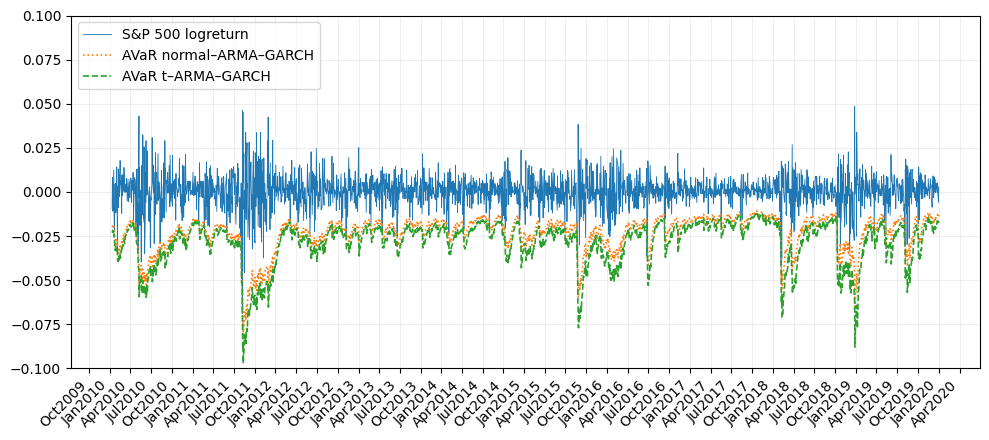

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# prepare data for plotting
plot_df = pd.concat(
    {
        "logreturn": y,
        "AVaR_norm": avar_norm_df["AVaR"],
        "AVaR_t":    avar_t_df["AVaR"],
    },
    axis=1, join="inner"
).dropna()


# plot
fig, ax = plt.subplots(figsize=(10, 4.5))

# main plot
ax.plot(plot_df.index, plot_df["logreturn"], lw=0.6, label="S&P 500 logreturn")
ax.plot(plot_df.index, plot_df["AVaR_norm"], ls=":",  lw=1.2, label="AVaR normal–ARMA–GARCH")
ax.plot(plot_df.index, plot_df["AVaR_t"],    ls="--", lw=1.2, label="AVaR t–ARMA–GARCH")

ax.set_ylim(-0.1, 0.1) # limit y-axis for better visibility
ax.set_xlabel("")



# date formatting similar to the paper
ax.xaxis.set_major_locator(MonthLocator(bymonth=[1,4,7,10]))  # quarterly ticks
ax.xaxis.set_major_formatter(DateFormatter("%b%Y"))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha("right")

ax.grid(alpha=0.2)
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig("AVaR_plot.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()
